In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
### Set time from to a certain number of years
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

### Create a list of tickers
tickers = ['SPY','BND','GLD','QQQ','VTI']

In [3]:
### Download the daily adjusted close prices for the tickers
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2008-09-29   83.355927  49.413876   89.570000   33.083328   42.843140
2008-09-30   86.806007  48.851822   85.070000   34.036800   43.981091
2008-10-01   86.858391  48.591858   85.970001   33.678143   43.928352
2008-10-02   83.707687  49.538376   82.330002   32.147316   41.953884
2008-10-03   82.577606  49.266106   82.589996   31.648708   41.313293
...                ...        ...         ...         ...         ...
2023-09-18  443.630005  70.860001  179.389999  370.660004  220.242844
2023-09-19  442.709991  7

In [14]:
### Calculate the daily log returns and drop any NAs
### Because its easier to add log returns 
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
###  Delete any not applicable values
log_returns  = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2008-09-30  0.040556 -0.011440 -0.051546  0.028413  0.026214
2008-10-01  0.000603 -0.005336  0.010524 -0.010593 -0.001200
2008-10-02 -0.036948  0.019292 -0.043263 -0.046520 -0.045989
2008-10-03 -0.013592 -0.005511  0.003153 -0.015632 -0.015387
2008-10-06 -0.052277 -0.008059  0.020256 -0.037166 -0.035463
...              ...       ...       ...       ...       ...
2023-09-18  0.000586  0.000988  0.005870  0.001042  0.000091
2023-09-19 -0.002076 -0.002119 -0.000948 -0.002134 -0.002537
2023-09-20 -0.009236 -0.001274  0.000725 -0.014515 -0.008883
2023-09-21 -0.016666 -0.006250 -0.007275 -0.018495 -0.016914
2023-09-22 -0.002251  0.004124  0.003196  0.000140 -0.002104

[3771 rows x 5 columns]


In [7]:
### Create a function that will be used to calculate portfolio expected return
###We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

### Create a function that will be used to calculate portfolio standard deviation
### Corelation matrix finds correlation of each stock with each other

def standard_deviation (weights, cov_matrix):
    ### transpose of weight * matrix * original weight matrix
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [8]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

              SPY           BND       GLD           QQQ           VTI
SPY  1.629367e-04  4.546846e-07  0.000010  1.673491e-04  1.637617e-04
BND  4.546846e-07  1.059812e-05  0.000008  1.366075e-07  3.404679e-07
GLD  9.588169e-06  8.461225e-06  0.000112  9.279010e-06  1.061590e-05
QQQ  1.673491e-04  1.366075e-07  0.000009  2.001966e-04  1.694562e-04
VTI  1.637617e-04  3.404679e-07  0.000011  1.694562e-04  1.665289e-04


In [9]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
## equally weighted
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

In [10]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)
### portfolio_value * portfolio_expected_return * days= expected return over than number of days
### this factors in volatility

In [11]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [12]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
### if days increase var increases , if confidence interval increases var increases
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

78283.67117254253


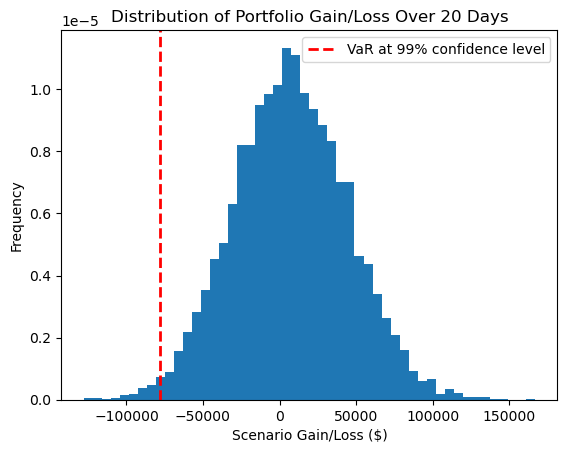

In [13]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()